# **1. Import Library**

Mengimport library yang dibutuhkan

In [67]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **2. Load Dataset**

Membaca dataset.

In [68]:
# Muat kedua dataset yang relevan
rating = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

Menampilkan sample data rating

In [69]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# **3. Data Wrangling**

Cek missing value

In [70]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


**Insight**:
- Tidak ada missing value ditemukan pada dataset. Hal ini penting untuk memastikan data yang digunakan sudah lengkap dan siap diproses lebih lanjut.


In [71]:
#Cek Data Dupliat
duplikat = rating.duplicated().sum()
print(duplikat)

1


**Insight**
- Terdapat 1 duplikat ditemukan pada dataset. Data duplikat ini akan dihapus pada tahap Prepraration


<ipython-input-72-289680df3178>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=rating, palette='viridis')


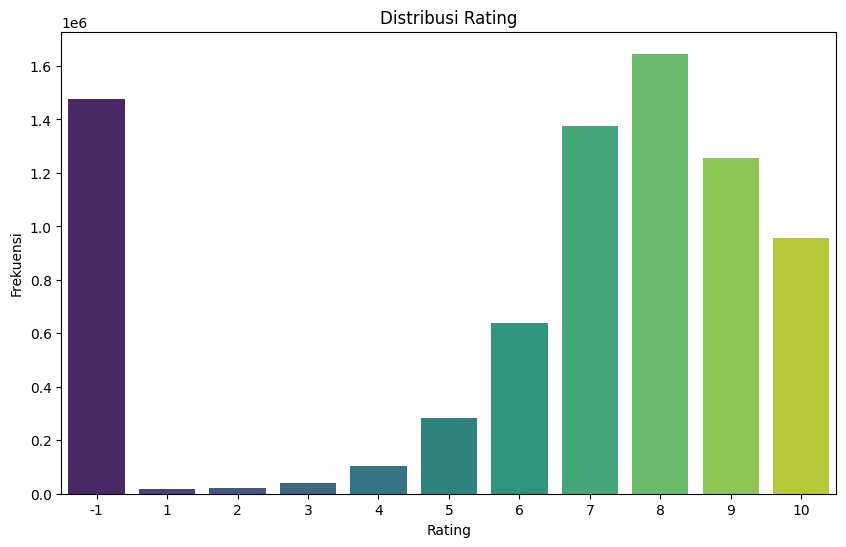

In [72]:
#distribusi data pada fitur rating
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=rating, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

**Insight**
- Visualisasi distribusi data rating ini menyajikan gambaran komprehensif mengenai perilaku pengguna, yang terbagi menjadi dua pola utama. Pertama, lonjakan frekuensi yang sangat signifikan pada rating -1 menunjukkan bahwa sebagian besar interaksi adalah catatan 'telah ditonton' tanpa disertai skor numerik. Ini merupakan sinyal ketertarikan yang sangat berharga meskipun tanpa adanya penilaian angka. Kedua, untuk data rating yang memiliki skor (skala 1-10), distribusinya sangat condong ke kiri, dengan mayoritas pengguna memberikan rating tinggi seperti 7, 8, 9, dan 10. Hal ini menandakan adanya bias positif yang kuat, di mana pengguna cenderung hanya memberikan penilaian pada anime yang mereka nikmati. Distribusi yang unik ini memiliki implikasi penting bagi sistem rekomendasi yang akan dibangun: model tidak hanya harus mampu menangani bias penilaian positif ini, tetapi juga harus bisa memanfaatkan data dari pengguna yang menandai anime sebagai 'telah ditonton' (rating -1) untuk menghasilkan rekomendasi yang lebih akurat dan personal.

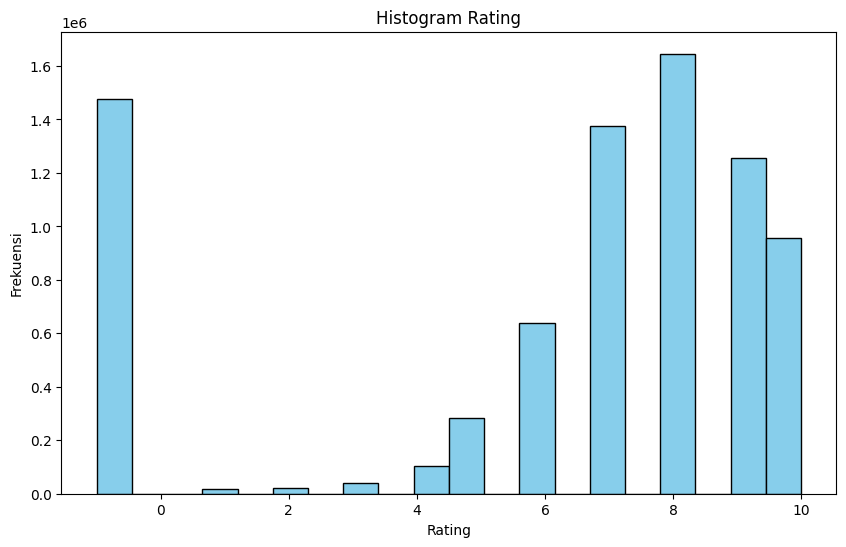

In [73]:
#histogram dari fitur rating
plt.figure(figsize=(10, 6))
plt.hist(rating['rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

**Insight**
- Histogram di atas menunjukkan distribusi rating pengguna yang memiliki dua pola yang sangat jelas.
Pertama, terdapat lonjakan frekuensi yang sangat tinggi pada rating -1 (ditampilkan di dekat angka 0). Ini menandakan bahwa sebagian besar data adalah catatan anime yang telah ditonton oleh pengguna tetapi tidak diberi skor (umpan balik implisit).
Kedua, untuk rating sebenarnya (skala 1-10), distribusi sangat condong ke arah nilai tinggi (7, 8, 9, dan 10). Hal ini menunjukkan bahwa pengguna cenderung memberikan ulasan positif pada anime yang mereka putuskan untuk dinilai, sementara rating rendah sangat jarang diberikan.

Memvisualisasi fitur rating dengan boxplot untuk melihat korelasi atau insight lain.

<ipython-input-74-bdaad32d1186>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', data=rating, palette='viridis')


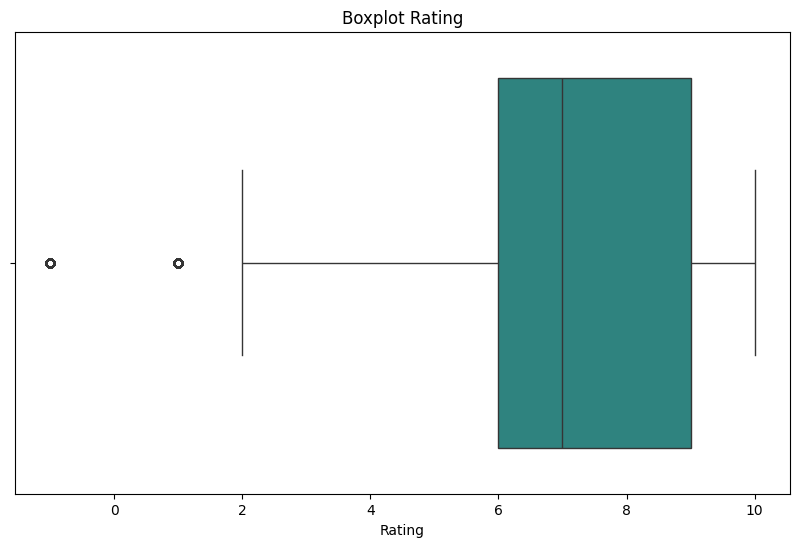

In [74]:
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', data=rating, palette='viridis')
plt.title('Boxplot Rating')
plt.xlabel('Rating')
plt.show()

**Insight**
- Kotak Utama (Interquartile Range - IQR)
    Bagian kotak (box) berwarna hijau kebiruan membentang dari rating 6 (kuartil pertama, Q1) hingga rating 9 (kuartil ketiga, Q3). Ini adalah informasi kunci yang berarti 50% dari seluruh rating yang diberikan oleh pengguna berada dalam rentang ini. Ini bisa dianggap sebagai rentang penilaian yang paling "tipikal" atau umum.
- Garis Median (Nilai Tengah)
    Garis vertikal di dalam kotak berada pada rating 7. Ini adalah median atau nilai tengah dari seluruh data rating. Fakta bahwa nilai tengahnya adalah 7 menegaskan kembali bahwa distribusi data sangat condong ke arah nilai yang tinggi.
- Whisker (Jangkauan Data Normal)
    - Garis horizontal (whisker) di sebelah kanan membentang hingga rating 10, menunjukkan bahwa ini adalah nilai maksimum yang masih berada dalam jangkauan data yang dianggap normal.
    - Whisker di sebelah kiri berhenti di sekitar rating 2, menandakan ini adalah batas bawah dari data normal sebelum suatu nilai dianggap sebagai outlier.
- Outlier (Nilai Ekstrem)
    Titik-titik individual yang berada di sebelah kiri whisker (secara spesifik pada rating -1 dan 1) diidentifikasi sebagai outlier. Ini adalah nilai-nilai yang secara statistik sangat jarang terjadi dan berada jauh di luar jangkauan sebagian besar data rating. Ini mengkonfirmasi bahwa rating sangat rendah dan status "telah ditonton" tanpa skor adalah kejadian yang tidak biasa dibandingkan dengan distribusi utama rating 6-10.

**Insight**
-

# **4. Data Preparation**

In [76]:
print("--- Proses Optimasi Data ---")
print(f"Jumlah baris data rating asli: {len(rating)}")

--- Proses Optimasi Data ---
Jumlah baris data rating asli: 7813737


In [77]:
#Menghapus data duplikat
rating = rating.drop_duplicates()


In [78]:
#Hapus data rating -1 (fokus pada rating eksplisit)
rating_df = rating[rating['rating'] != -1]
print(f"Jumlah baris setelah menghapus rating -1: {len(rating_df)}")

Jumlah baris setelah menghapus rating -1: 6337240


In [79]:
#Hitung jumlah rating per pengguna dan per anime
user_counts = rating_df['user_id'].value_counts()
anime_counts = rating_df['anime_id'].value_counts()

In [80]:
#Filter data berdasarkan jumlah rating
MIN_USER_RATINGS = 50
MIN_ANIME_RATINGS = 50

In [81]:
# Filter pengguna dan anime yang tidak memenuhi ambang batas
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
popular_anime = anime_counts[anime_counts >= MIN_ANIME_RATINGS].index

rating_filtered = rating_df[
    rating_df['user_id'].isin(active_users) &
    rating_df['anime_id'].isin(popular_anime)
]
print(f"Jumlah baris setelah filtering (pengguna > {MIN_USER_RATINGS} rating, anime > {MIN_ANIME_RATINGS} rating): {len(rating_filtered)}")
print("----------------------------\n")

Jumlah baris setelah filtering (pengguna > 50 rating, anime > 50 rating): 5633890
----------------------------



In [27]:
# Buat pemetaan (encoding) untuk user dan anime dari data yang sudah difilter
user_ids = rating_filtered['user_id'].unique()
anime_ids = rating_filtered['anime_id'].unique()

In [28]:
user_to_index = {user_id: i for i, user_id in enumerate(user_ids)}
index_to_user = {i: user_id for i, user_id in enumerate(user_ids)}

anime_to_index = {anime_id: i for i, anime_id in enumerate(anime_ids)}
index_to_anime = {i: anime_id for i, anime_id in enumerate(anime_ids)}

In [59]:
# Terapkan mapping ke dataframe
rating_filtered = rating_filtered.copy()
rating_filtered['user'] = rating_filtered['user_id'].map(user_to_index)
rating_filtered['anime'] = rating_filtered['anime_id'].map(anime_to_index)

In [30]:
# Normalisasi rating
min_rating = rating_filtered['rating'].min()
max_rating = rating_filtered['rating'].max()
rating_filtered['rating_norm'] = rating_filtered['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

<ipython-input-30-d94469fdecd2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_filtered['rating_norm'] = rating_filtered['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))


In [31]:
# Siapkan data input (x) dan target (y)
x = rating_filtered[['user', 'anime']].values
y = rating_filtered['rating_norm'].values


# **5. Data Splitting**

In [32]:
# Acak data
np.random.seed(42)
shuffled_indices = np.random.permutation(len(rating_filtered))
x_shuffled = x[shuffled_indices]
y_shuffled = y[shuffled_indices]

In [33]:
# Bagi data menjadi 80% training dan 20% validasi
train_size = int(0.8 * len(x_shuffled))
x_train, x_val = x_shuffled[:train_size], x_shuffled[train_size:]
y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:]

print(f"Jumlah data training: {len(x_train)}")
print(f"Jumlah data validasi: {len(x_val)}")

Jumlah data training: 4507112
Jumlah data validasi: 1126779


# **6. Model Building**

## 6.1. RecommenderNet

Melakukan model building dengan RecommenderNet dan Mengkompilasi model dengan Binary Crossentropy dan menggunakan optimizer Adam serta metric RMSE.

In [ ]:
# Variabel yang akan digunakan oleh kedua model
num_users = len(user_to_index)
num_animes = len(anime_to_index)
EMBEDDING_SIZE = 32

In [34]:
# --- 6.1. Model RecommenderNet ---
print("--- Membangun Model 1: RecommenderNet ---")

# Definisi kelas
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_animes, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_animes = num_animes
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.anime_embedding = layers.Embedding(num_animes, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.anime_bias = layers.Embedding(num_animes, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])
        dot_user_anime = tf.reduce_sum(user_vector * anime_vector, axis=1, keepdims=True)
        x = dot_user_anime + user_bias + anime_bias
        return tf.nn.sigmoid(x)

# Instansiasi dan kompilasi model RecommenderNet
recommender_net_model = RecommenderNet(num_users, num_animes, EMBEDDING_SIZE)
recommender_net_model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
print("Model RecommenderNet berhasil dibuat dan dikompilasi.")

--- Membangun Model 1: RecommenderNet ---
Model RecommenderNet berhasil dibuat dan dikompilasi.


## 6.2. NeuMF

In [36]:
# --- 6.2. Model NeuMF ---
print("\n--- Membangun Model 2: NeuMF ---")

# Definisi fungsi
def get_NeuMF_model(num_users, num_items, mf_dim=8, mlp_layers=[64,32,16,8], dropout=0.0):
    user_input = Input(shape=(1,), name="user_input")
    item_input = Input(shape=(1,), name="item_input")
    # MF part
    mf_user_embedding = layers.Embedding(num_users, mf_dim, name="mf_user_embedding")(user_input)
    mf_item_embedding = layers.Embedding(num_items, mf_dim, name="mf_item_embedding")(item_input)
    mf_vector = layers.multiply([layers.Flatten()(mf_user_embedding), layers.Flatten()(mf_item_embedding)])
    # MLP part
    mlp_embedding_dim = mlp_layers[0] // 2
    mlp_user_embedding = layers.Embedding(num_users, mlp_embedding_dim, name="mlp_user_embedding")(user_input)
    mlp_item_embedding = layers.Embedding(num_items, mlp_embedding_dim, name="mlp_item_embedding")(item_input)
    mlp_vector = layers.concatenate([layers.Flatten()(mlp_user_embedding), layers.Flatten()(mlp_item_embedding)])
    for idx, units in enumerate(mlp_layers[1:]):
        mlp_vector = layers.Dense(units, activation='relu', name=f"mlp_dense_{idx}")(mlp_vector)
        if dropout > 0:
            mlp_vector = layers.Dropout(dropout)(mlp_vector)
    # Concatenate
    neumf_vector = layers.concatenate([mf_vector, mlp_vector])
    prediction = layers.Dense(1, activation="sigmoid", name="prediction")(neumf_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

# Instansiasi dan kompilasi model NeuMF
neuMF_model = get_NeuMF_model(num_users, num_animes)
neuMF_model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
print("Model NeuMF berhasil dibuat dan dikompilasi.")


--- Membangun Model 2: NeuMF ---
Model NeuMF berhasil dibuat dan dikompilasi.


# **7. Model Training**

Menerapkan Callbacks early stoping untuk menghentikan model ketika val_loss tidak berkurang selama 3 epoch dan merestore kembali weight yang terbaik.

In [37]:
# Definisikan hyperparameter dan callbacks untuk training
BATCH_SIZE = 256 # Batch size yang lebih besar untuk training lebih cepat
EPOCHS = 20      # Jumlah epoch maksimal (bisa berhenti lebih awal karena EarlyStopping)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, # Kurangi learning rate sebesar 50%
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

## 7.1. RecommenderNet

In [38]:
print("\n--- Memulai Pelatihan Model 1: RecommenderNet ---")
history_recommender = recommender_net_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


--- Memulai Pelatihan Model 1: RecommenderNet ---
Epoch 1/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.0376 - root_mean_squared_error: 0.1825 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1347 - learning_rate: 0.0010
Epoch 2/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1332 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1316 - learning_rate: 0.0010
Epoch 3/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312 - learning_rate: 0.0010
Epoch 4/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312 - learning_rate: 0.0010
Epoch 5/20
17598/17606 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17606/17606 ━━━━━━━━

## 7.2. NeuMF

In [39]:
print("\n--- Memulai Pelatihan Model 2: NeuMF ---")
history_neuMF = neuMF_model.fit(
    [x_train[:, 0], x_train[:, 1]], y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    callbacks=callbacks
)


--- Memulai Pelatihan Model 2: NeuMF ---
Epoch 1/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - loss: 0.0204 - root_mean_squared_error: 0.1420 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283 - learning_rate: 0.0010
Epoch 2/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1255 - learning_rate: 0.0010
Epoch 3/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1198 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249 - learning_rate: 0.0010
Epoch 4/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1247 - learning_rate: 0.0010
Epoch 5/20
17606/17606 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243 - learning_rate: 0.0010
Epoch 6/20
17606/17606 

# **8. Model Evaluation**

## 8.1. Plot History Training

Membandingkan dua model rekomendasi, RecommenderNet dan NeuMF, dengan menampilkan grafik yang menunjukkan bagaimana loss dan RMSE berubah selama pelatihan.

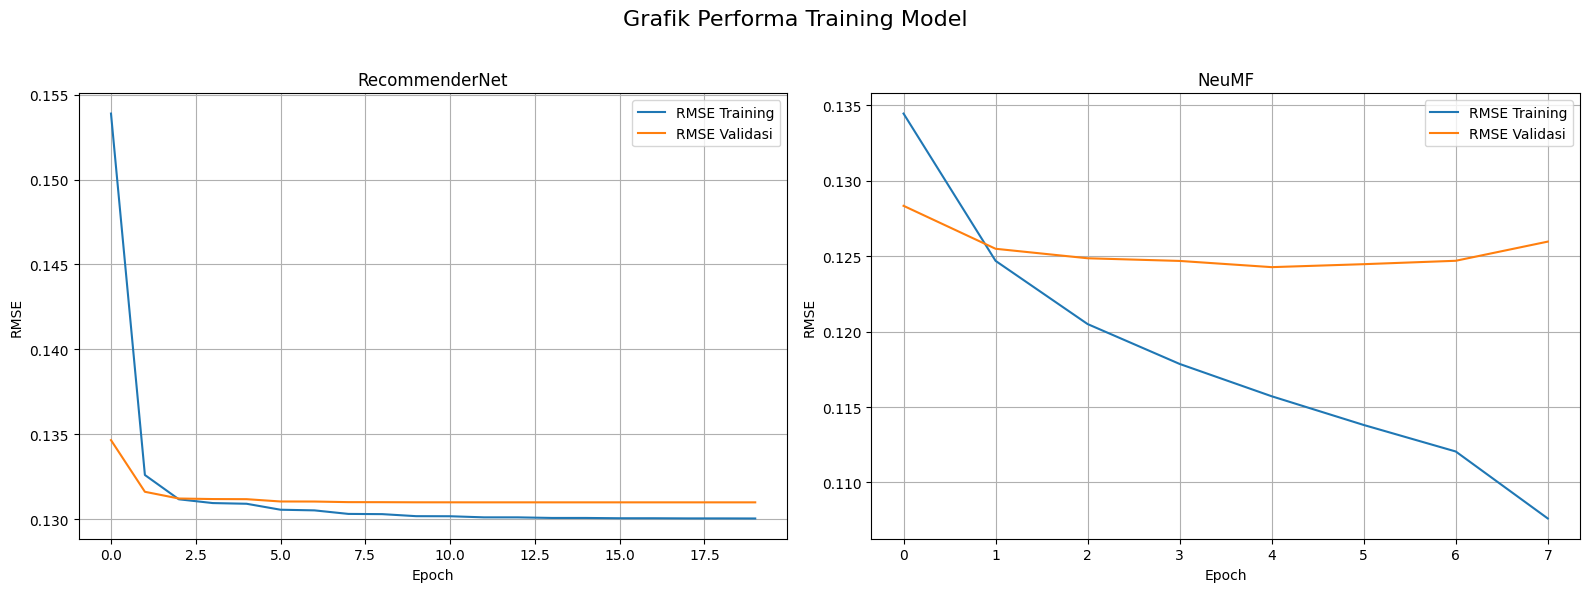

In [40]:
# Membuat figure untuk dua plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Grafik Performa Training Model', fontsize=16)

# Plot 1: RecommenderNet
ax1.plot(history_recommender.history['root_mean_squared_error'], label='RMSE Training')
ax1.plot(history_recommender.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax1.set_title('RecommenderNet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(True)

# Plot 2: NeuMF
ax2.plot(history_neuMF.history['root_mean_squared_error'], label='RMSE Training')
ax2.plot(history_neuMF.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax2.set_title('NeuMF')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 8.2. Metrik Error (RMSE, MAE)

Membandingkan kinerja dua model rekomendasi, RecommenderNet dan NeuMF, dengan menghitung beberapa metrik evaluasi seperti RMSE dan MAE

In [41]:
# Prediksi dari kedua model pada data validasi
pred_recommender = recommender_net_model.predict(x_val).flatten()
pred_neuMF = neuMF_model.predict([x_val[:, 0], x_val[:, 1]]).flatten()

# Mengembalikan nilai prediksi dan aktual ke skala rating asli
y_val_rescaled = y_val * (max_rating - min_rating) + min_rating
pred_recommender_rescaled = pred_recommender * (max_rating - min_rating) + min_rating
pred_neuMF_rescaled = pred_neuMF * (max_rating - min_rating) + min_rating

# Hitung metrik untuk RecommenderNet
rmse_recommender = np.sqrt(mean_squared_error(y_val_rescaled, pred_recommender_rescaled))
mae_recommender = mean_absolute_error(y_val_rescaled, pred_recommender_rescaled)

# Hitung metrik untuk NeuMF
rmse_neuMF = np.sqrt(mean_squared_error(y_val_rescaled, pred_neuMF_rescaled))
mae_neuMF = mean_absolute_error(y_val_rescaled, pred_neuMF_rescaled)

# Buat DataFrame untuk perbandingan
comparison_data = {
    "Metric": ["RMSE", "MAE"],
    "RecommenderNet": [rmse_recommender, mae_recommender],
    "NeuMF": [rmse_neuMF, mae_neuMF]
}
comparison_df = pd.DataFrame(comparison_data)
print("Perbandingan Metrik Evaluasi:")
print(comparison_df)

35212/35212 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
35212/35212 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step
Perbandingan Metrik Evaluasi:
  Metric  RecommenderNet     NeuMF
0   RMSE        1.178885  1.118508
1    MAE        0.892151  0.840907


## 8.3. Scatterplot : Actual Rating vs Predicted Rating

Scatter plot ini membandingkan akurasi model RecommenderNet dan NeuMF. Sumbu horizontal menunjukkan rating asli dari pengguna, sementara sumbu vertikal adalah rating hasil prediksi. Semakin dekat sebaran titik ke garis diagonal merah, semakin akurat prediksi model tersebut.

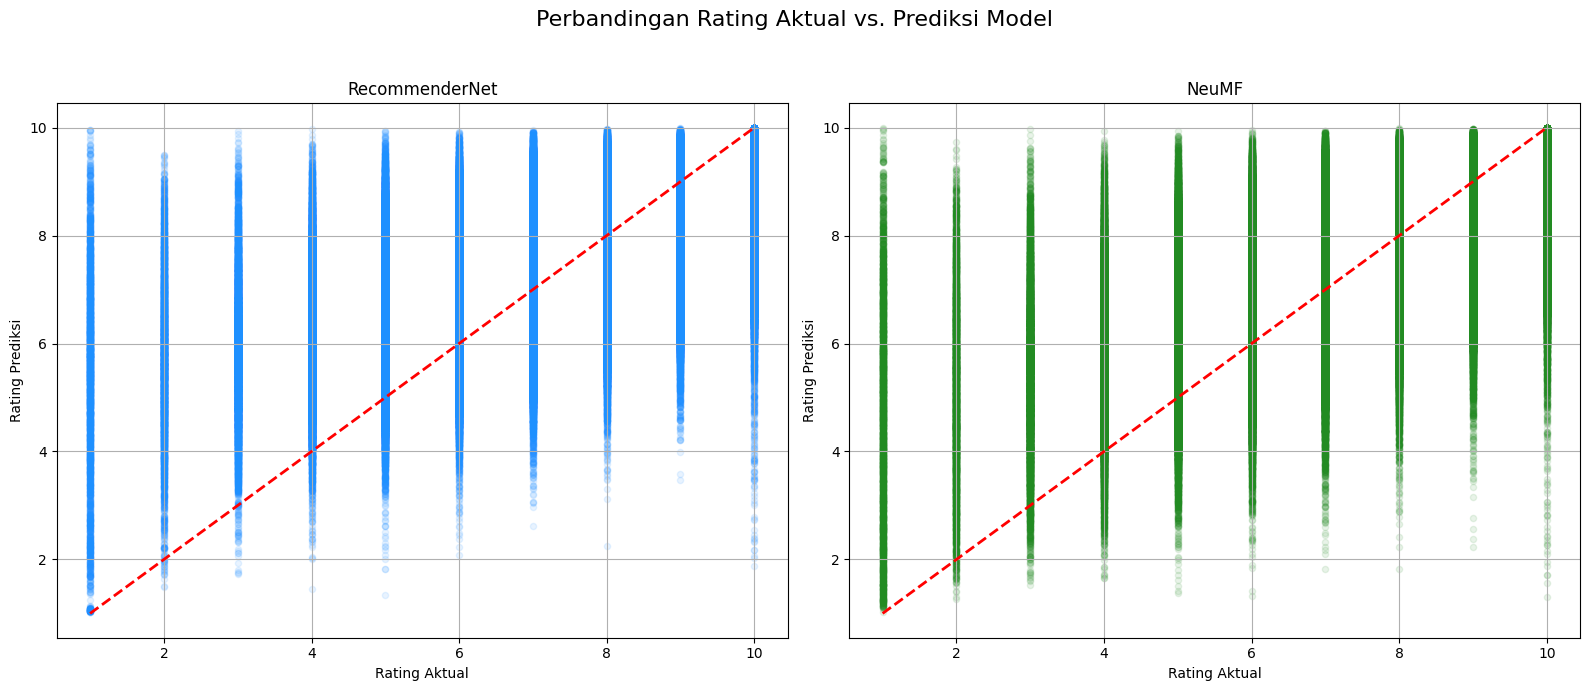

In [43]:
# Membuat figure dan axes untuk dua scatter plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Perbandingan Rating Aktual vs. Prediksi Model', fontsize=16)

# Plot 1: RecommenderNet
# alpha=0.1 digunakan agar tumpukan titik terlihat transparan
ax1.scatter(y_val_rescaled, pred_recommender_rescaled, alpha=0.1, color='dodgerblue', s=20)
# Garis merah menunjukkan prediksi yang sempurna (y=x)
ax1.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Rating Aktual')
ax1.set_ylabel('Rating Prediksi')
ax1.set_title('RecommenderNet')
ax1.grid(True)

# Plot 2: NeuMF
ax2.scatter(y_val_rescaled, pred_neuMF_rescaled, alpha=0.1, color='forestgreen', s=20)
ax2.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Rating Aktual')
ax2.set_ylabel('Rating Prediksi')
ax2.set_title('NeuMF')
ax2.grid(True)

# Menampilkan plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 8.4. Top-N

Membandingkan rekomendasi film dari dua model, RecommenderNet dan NeuMF, berdasarkan prediksi yang dihasilkan oleh masing-masing model.

In [45]:
# --- Contoh Penggunaan dan Tampilan Berdampingan ---

# Pilih satu user ID sampel dari data yang sudah kita filter
sample_user_id = rating_filtered['user_id'].iloc[0]
print(f"======================================================")
print(f"Menampilkan Rekomendasi Teratas untuk User ID: {sample_user_id}")
print(f"======================================================")

# Dapatkan rekomendasi dari kedua model menggunakan fungsi sederhana
top_recnet = get_top_n_recommendations_simple(sample_user_id, recommender_net_model, n=10, use_neumf=False)
top_neumf = get_top_n_recommendations_simple(sample_user_id, neuMF_model, n=10, use_neumf=True)

# Siapkan kedua dataframe untuk digabungkan
# Atur 'Rank' sebagai index dan beri nama ulang kolom agar tidak tumpang tindih
recnet_display = top_recnet.rename(
    columns={'name': 'Rekomendasi RecommenderNet', 'predicted_rating': 'Prediksi Rating'}
)[['Rank', 'Rekomendasi RecommenderNet', 'Prediksi Rating']].set_index('Rank')

neumf_display = top_neumf.rename(
    columns={'name': 'Rekomendasi NeuMF', 'predicted_rating': 'Prediksi Rating'}
)[['Rank', 'Rekomendasi NeuMF', 'Prediksi Rating']].set_index('Rank')

# Gabungkan kedua dataframe secara horizontal (kiri dan kanan)
comparison_table = pd.concat([recnet_display, neumf_display], axis=1)

# Tampilkan tabel perbandingan
print("\n--- Perbandingan Top-10 Rekomendasi ---")
display(comparison_table)

Menampilkan Rekomendasi Teratas untuk User ID: 3

--- Perbandingan Top-10 Rekomendasi ---


,Rekomendasi RecommenderNet,Prediksi Rating,Rekomendasi NeuMF,Prediksi Rating
Rank,,,,
1,Ginga Eiyuu Densetsu,9.631790,Gintama°,9.871418
2,Gintama°,9.495575,Hunter x Hunter (2011),9.820727
3,Kimi no Na wa.,9.373096,Ginga Eiyuu Densetsu,9.818521
4,Gintama&#039;,9.284569,Gintama,9.802258
5,Steins;Gate,9.265119,Gintama&#039;,9.799044
6,Gintama&#039;: Enchousen,9.246076,Gintama&#039;: Enchousen,9.777562
7,Hunter x Hunter (2011),9.242425,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,9.716660
8,Gintama,9.238415,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,9.689471
9,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,9.235682,Hajime no Ippo,9.661383
